## Preambule

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_6432\3550119306.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Read data

In [18]:
xr_dataread = xr.open_dataset("K:/ECEMF/T5.2/xr_dataread.nc") / 1e3
xr_eng = xr.open_dataset("K:/ECEMF/T5.2/xr_policyscen.nc") / 1e3

In [41]:
xr_eng = xr_eng.sel(Time=np.arange(2021, 2101))

<xarray.Dataset>
Dimensions:         (Scenario: 5, Region: 207, Time: 251, Conditionality: 3,
                     Hot_air: 2, Ambition: 2, Temperature: 10, Risk: 5,
                     NonCO2red: 5, NegEmis: 7, Timing: 2, Model: 9)
Coordinates: (12/14)
  * Scenario        (Scenario) <U4 'SSP1' 'SSP2' 'SSP3' 'SSP4' 'SSP5'
  * Region          (Region) <U16 'AFG' 'ALB' ... 'African Group' 'Umbrella'
  * Time            (Time) int32 1850 1851 1852 1853 ... 2097 2098 2099 2100
  * Conditionality  (Conditionality) <U13 'conditional' 'range' 'unconditional'
  * Hot_air         (Hot_air) <U7 'include' 'exclude'
  * Ambition        (Ambition) <U4 'low' 'high'
    ...              ...
  * NonCO2red       (NonCO2red) float64 0.1 0.33 0.5 0.67 0.9
  * NegEmis         (NegEmis) float64 0.2 0.3 0.4 0.5 0.6 0.7 0.8
  * Timing          (Timing) <U9 'Delayed' 'Immediate'
  * Model           (Model) <U21 'BLUES 2.0' 'COFFEE 1.5' ... 'WITCH 5.0'
    source          <U25 ...
    Version         <U6 ...
Data variables:
    NDC             (Model, Region, Time) float64 nan nan nan ... nan nan nan
    CurPol          (Model, Region, Time) float64 nan nan nan ... nan nan nan
    NetZero         (Model, Region, Time) float64 nan nan nan ... nan nan nan

In [19]:
rulecolors = (
    np.array(
        [
            (90, 51, 36),
            (141, 145, 31),
            (0, 156, 223),
            (157, 0, 100),
            (230, 173, 31),
            (61, 29, 92),
        ]
    )
    / 256
)

In [35]:
emis_2021 = float(xr_dataread.GHG_hist.sel(Region="EARTH", Time=2021))

## Harmonize

In [38]:
def harm(y):
    y = np.array(y.sel(Time=np.arange(2021, 2101)))
    comp = np.sqrt(np.linspace(0, 1, len(y)))
    comp = comp / np.sum(comp)
    offset = y[0] - emis_2021
    ynew = y + offset * comp
    return y

## Plot

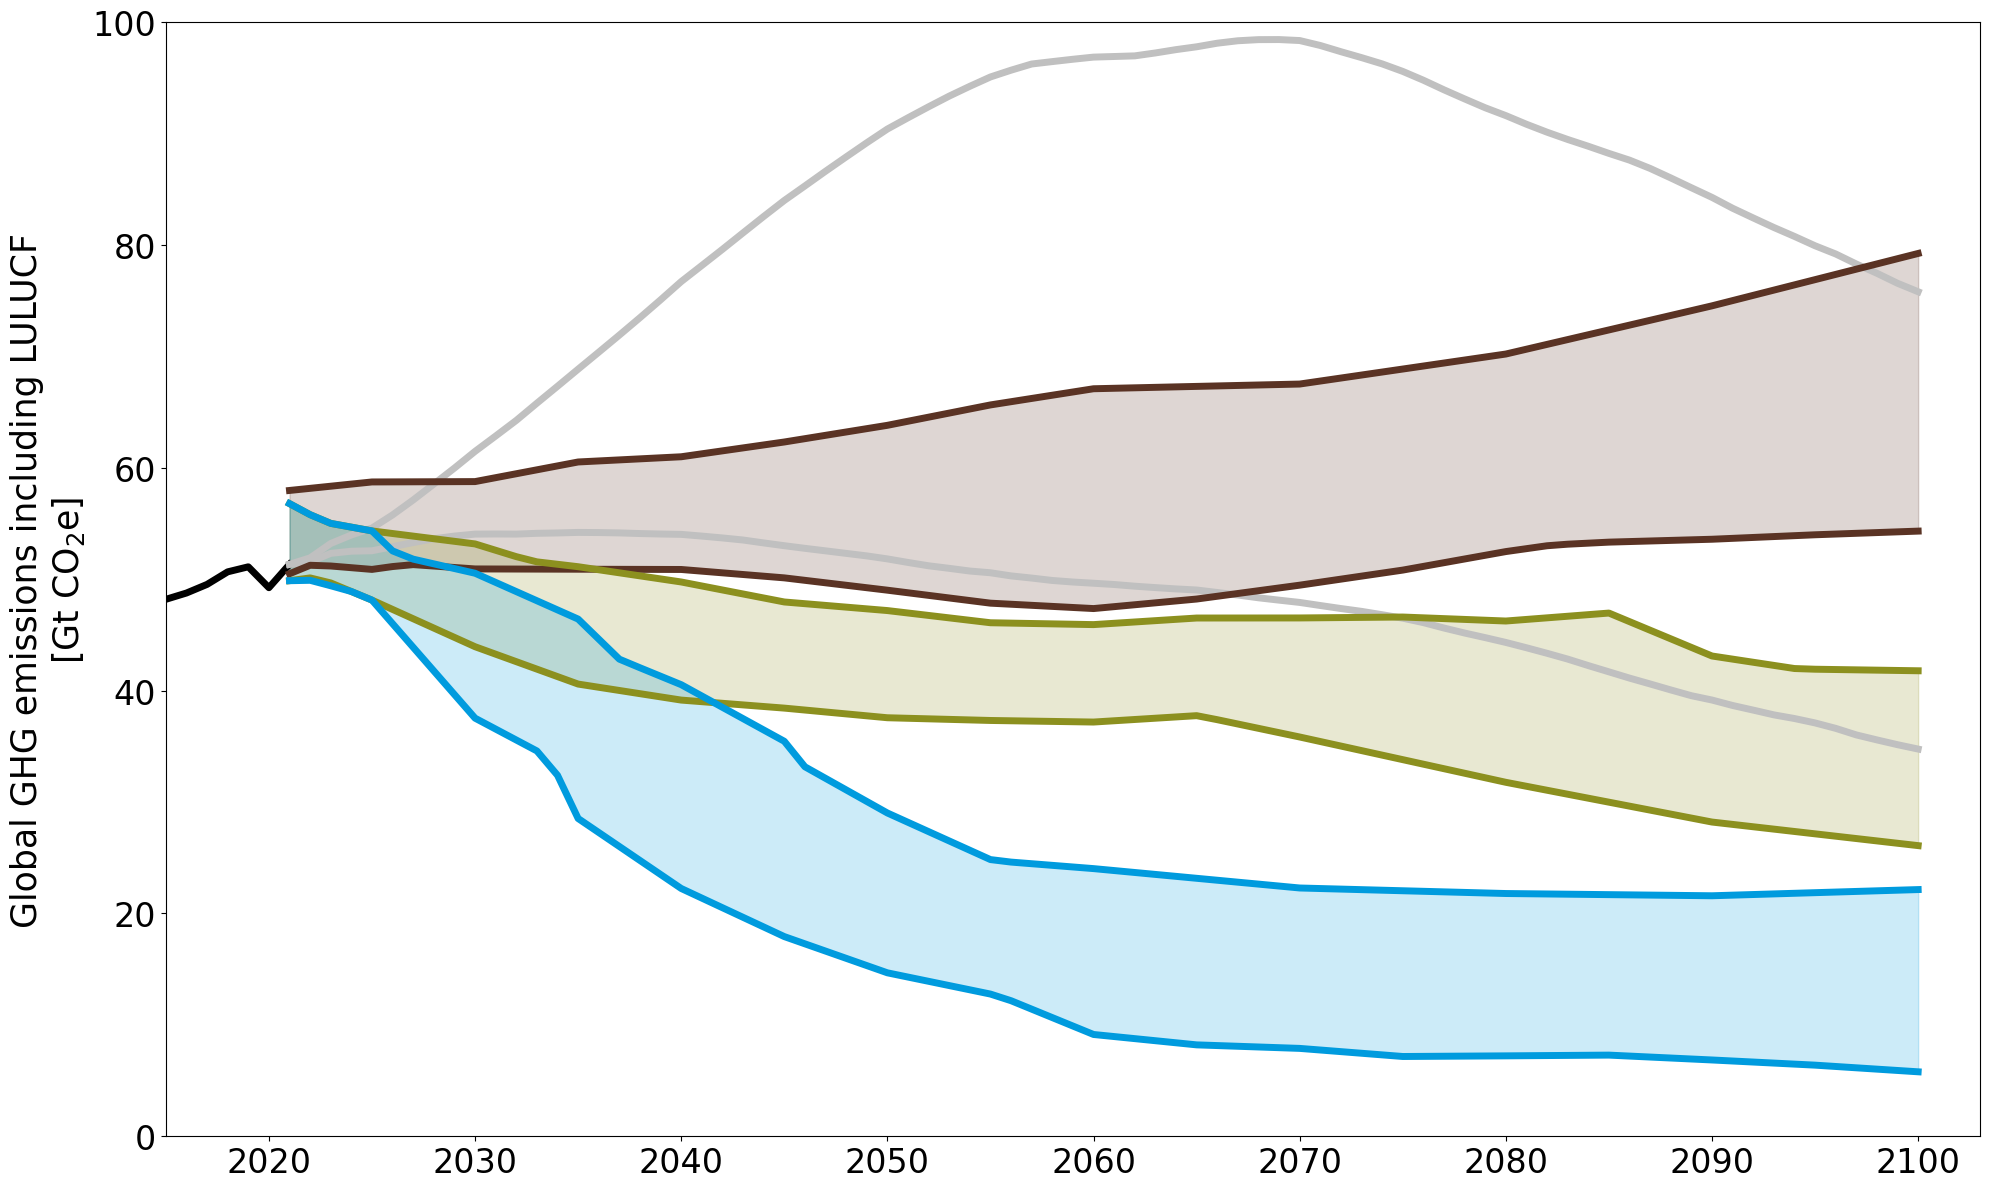

In [40]:
fig, ax = plt.subplots(figsize=(20, 12), facecolor="w")
ax.set_xlim([2015, 2103])
ax.set_ylim([0, 100])

ax.plot(
    xr_dataread.Time,
    xr_dataread.GHG_hist.sel(Region="EARTH"),
    lw=5,
    c="k",
    label="Historical emissions",
)
timeline = np.arange(2021, 2101)

# Baseline
y1 = xr_dataread.GHG_base.sel(Region="EARTH").min(dim="Scenario")
y2 = xr_dataread.GHG_base.sel(Region="EARTH").max(dim="Scenario")
ax.plot(timeline, y1, lw=5, c="silver", label="Baseline emissions")
ax.plot(timeline, y2, lw=5, c="silver")
ax.fill_between(timeline, y1, y2, where=y1 >= y2, color="silver", alpha=0.2)

# CurPol
y1 = xr_eng.CurPol.sel(Region="EARTH").max(dim="Model")
y2 = xr_eng.CurPol.sel(Region="EARTH").min(dim="Model")
ax.plot(timeline, y1, lw=5, c=rulecolors[0], label="Current policies")
ax.plot(timeline, y2, lw=5, c=rulecolors[0])
ax.fill_between(timeline, y1, y2, where=y1 >= y2, color=rulecolors[0], alpha=0.2)

# NDC
y1 = xr_eng.NDC.sel(Region="EARTH").max(dim="Model")
y2 = xr_eng.NDC.sel(Region="EARTH").min(dim="Model")
ax.plot(timeline, y1, lw=5, c=rulecolors[1], label="Nationally determined contributions (NDCs)")
ax.plot(timeline, y2, lw=5, c=rulecolors[1])
ax.fill_between(timeline, y1, y2, where=y1 >= y2, color=rulecolors[1], alpha=0.2)

# NDC
y1 = xr_eng.NetZero.sel(Region="EARTH").max(dim="Model")
y2 = xr_eng.NetZero.sel(Region="EARTH").min(dim="Model")
ax.plot(timeline, y1, lw=5, c=rulecolors[2], label="Net-zero pledges")
ax.plot(timeline, y2, lw=5, c=rulecolors[2])
ax.fill_between(timeline, y1, y2, where=y1 >= y2, color=rulecolors[2], alpha=0.2)

# ax.plot([-1e3, 1e5], [0, 0], 'k', zorder=-1e9)

ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.set_tick_params(labelsize=24)
ax.set_ylabel("Global GHG emissions including LULUCF\n[Gt CO$_2$e]", fontsize=25)
fig.tight_layout()
# plt.savefig("X:/user/dekkerm/Projects/ECEMF_T5.2/Figures/PBL_report/Fig_Ch2_ndc.png", dpi=250)